# Imputation Research Project <img src="https://miro.medium.com/max/1400/1*JPZcoAD9kERfEQxwlaPT-A.jpeg" alt="Alt text image not displaying" width="500" align="right" />
## Notebook 1.1: Exploratory Data Analysis

**Author:** Chike Odenigbo

**Date:** November 25th, 2022

**Notebook Structure:**

* 1.0 Preprocessing

* **1.1 Exploratory Data Analysis**

* 1.2 Masking

* 2.* Models


Water Sugar Alcohol

In [1]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import globalenv

import pandas as pd
from scipy.stats import variation
from src.preprocessing.preprocessing import NumericalVariableCleaner, NumericalMasker # utility preprocessing packages found in src folder
import os
from src.visualization.visualize import histogram, box_plot, bar_plot
from itertools import chain, combinations
from pathlib import Path
from notebook_config import ROOT_DIR # setup.py file changed the root of the project so it is set in the config file
ROOT_DIR = ROOT_DIR.as_posix() # convert root path to windows readable path (i.e. change backslash to forward slash)
import json
import numpy as np
import functools as ft

Unable to determine R home: [WinError 2] The system cannot find the file specified


In [2]:
notebook_nm = '2.0-masking'
fig_dir = f'{ROOT_DIR}/reports/figures/'
output_prefix = notebook_nm

In [3]:
def convert_masked_rows_to_na(mask_df,target_col):
    output_df = mask_df
#     output_df[target_col] = output_df[target_col].where(output_df[f'mask_ind_{target_col}'] != 1)
    output_df[f'{target_col}_na'] = np.where(output_df[f'mask_ind_{target_col}'] == 1, np.nan, output_df[target_col])
#     output_df[f'{target_col}'] = np.where(output_df[f'mask_ind_{target_col}'] == 1, np.nan, output_df[target_col])
    output_df = output_df.drop([f'mask_ind_{target_col}', target_col], axis=1)
#     output_df[f'{target_col}_na'].name = target_col
    output_df.rename(columns = {f'{target_col}_na':target_col}, inplace = True)
    return output_df

In [4]:
pd.set_option('display.max_columns', None)
nutrition_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_numerical.csv').dropna(axis = 'rows').reset_index(drop = True)
nutrition_df

name  serving_size  \
0                                          Nuts, pecans           100   
1                                        Teff, uncooked           100   
2                                       Sherbet, orange           100   
3                                      Cauliflower, raw           100   
4                                      Taro leaves, raw           100   
...                                                 ...           ...   
7194  Beef, raw, all grades, trimmed to 0" fat, sepa...           100   
7195  Lamb, cooked, separable lean only, composite o...           100   
7196  Lamb, raw, separable lean and fat, composite o...           100   
7197  Beef, raw, all grades, trimmed to 0" fat, sepa...           100   
7198  Beef, raw, all grades, trimmed to 0" fat, sepa...           100   

      total_fat  saturated_fat  cholesterol  sodium  choline  folate  \
0          72.0            6.2            0     0.0     40.5    22.0   
1           2.4            0.4            0    12.0     13.1     0.0   
2           2.0            1.2            1    46.0      7.7     4.0   
3           0.3            0.1            0    30.0     44.3    57.0   
4           0.7            0.2            0     3.0     12.8   126.0   
...         ...            ...          ...     ...      ...     ...   
7194        3.5            1.4           62    54.0     64.5     4.0   
7195        8.9            3.9          109    50.0      0.0     0.0   
7196       23.0           12.0           78    39.0      0.0     1.0   
7197        3.0            1.1           60    53.0     64.2     4.0   
7198        3.0            1.1           60    53.0     64.2     4.0   

      folic_acid  niacin  pantothenic_acid  riboflavin  thiamin  vitamin_a  \
0            0.0   1.167             0.863       0.130    0.660       56.0   
1            0.0   3.363             0.942       0.270    0.390        9.0   
2            0.0   0.063             0.224       0.097    0.027       46.0   
3            0.0   0.507             0.667       0.060    0.050        0.0   
4            0.0   1.513             0.084       0.456    0.209     4825.0   
...          ...     ...               ...         ...      ...        ...   
7194         0.0   6.422             0.356       0.234    0.063       11.0   
7195         0.0   7.680             0.580       0.500    0.130        0.0   
7196         0.0   6.550             0.520       0.320    0.130        0.0   
7197         0.0   6.720             0.355       0.184    0.063        4.0   
7198         0.0   6.720             0.355       0.184    0.063        6.0   

      vitamin_a_rae  carotene_alpha  carotene_beta  cryptoxanthin_beta  \
0               3.0             0.0           29.0                 9.0   
1               0.0             0.0            5.0                 0.0   
2              12.0             0.0            1.0                 5.0   
3               0.0             0.0            0.0                 0.0   
4             241.0             0.0         2895.0                 0.0   
...             ...             ...            ...                 ...   
7194            3.0             0.0            0.0                 0.0   
7195            0.0             0.0            0.0                 0.0   
7196            0.0             0.0            0.0                 0.0   
7197            1.0             0.0            0.0                 0.0   
7198            2.0             0.0            0.0                 0.0   

      lutein_zeaxanthin  vitamin_b12  vitamin_b6  vitamin_c  vitamin_d  \
0                  17.0         0.00       0.210        1.1        0.0   
1                  66.0         0.00       0.482        0.0        0.0   
2                   7.0         0.13       0.023        2.3        0.0   
3                   1.0         0.00       0.184       48.2        0.0   
4                1932.0         0.00       0.146       52.0        0.0   
...                 ...          ...   

In [5]:
masker = NumericalMasker()
mask_water_df = masker.mask(nutrition_df, 'water', k = 1, n = None, no_cols_frac = None, no_cols = 2, prob_range_non_mask = (0,0.3), prob_range_mask = (0.9,1), frac_na=0.2, rank_method = 'first', normalize_weights = False, selected_cols = None, seed = None,  max_corr = 0.9, min_corr = 0.3, col_weights = None)
mask_water_df[mask_water_df['mask_ind_water']==1]
na_water_df = convert_masked_rows_to_na(mask_water_df,'water')
na_water_df[na_water_df['water'].isnull()]

INFO:root:Starting masking process for the water field.
INFO:root:Selecting key columns.
INFO:root:Masking 1439 rows which make up for 19.99% of the observations into 1 clusters.
INFO:root:Finished creating correlation matrix.
INFO:root:Finished creating ranking matrix.
INFO:root:Finished ordering similar rows.
INFO:root:Finished creating clusters in the dataframe.
INFO:root:Finished creating index weights.


name  serving_size  \
5                                     Lamb, raw, ground           100   
12                               Peppers, raw, jalapeno           100   
23                               Cookies, Marie biscuit           100   
29                               Gravy, mix, dry, onion           100   
40                                Egg custards, dry mix           100   
...                                                 ...           ...   
7168  Beef, braised, cooked, choice, trimmed to 0" f...           100   
7180  Beef, grilled, cooked, all grades, trimmed to ...           100   
7186  Beef, broiled, cooked, all grades, trimmed to ...           100   
7189  Beef, braised, cooked, all grades, trimmed to ...           100   
7193  Beef, raw, all grades, trimmed to 0" fat, sepa...           100   

      total_fat  saturated_fat  cholesterol  sodium  choline  folate  \
5          23.0           10.0           73    59.0     69.3    18.0   
12          0.4            0.1            0     3.0      7.5    27.0   
23         11.0            5.3            0   370.0     27.0   118.0   
29          3.0            1.9            2  4186.0      0.0    31.0   
40          6.4            2.0          258   281.0      0.0    30.0   
...         ...            ...          ...     ...      ...     ...   
7168        8.3            2.8           97    60.0    100.6     8.0   
7180        5.8            2.4           82    68.0     88.7     7.0   
7186        5.4            1.8           63    71.0     98.6     8.0   
7189       18.0            7.3          106    48.0    109.8     9.0   
7193        3.3            1.3           62    54.0     64.6     4.0   

      folic_acid  niacin  pantothenic_acid  riboflavin  thiamin  vitamin_a  \
5            0.0   5.960             0.650       0.210    0.110        0.0   
12           0.0   1.280             0.315       0.070    0.040     1078.0   
23          98.0   3.861             0.000       0.493    0.541        3.0   
29          17.0   3.700             0.100       0.400    0.200        0.0   
40           0.0   0.320             2.238       0.412    0.145      217.0   
...          ...     ...               ...         ...      ...        ...   
7168         0.0   4.923             0.830       0.282    0.080        5.0   
7180         0.0   5.542             0.790       0.225    0.090        5.0   
7186         0.0   3.635             0.000       0.230    0.111        0.0   
7189         0.0   4.087             0.568       0.171    0.059        0.0   
7193         0.0   6.433             0.357       0.235    0.064       11.0   

      vitamin_a_rae  carotene_alpha  carotene_beta  cryptoxanthin_beta  \
5               0.0             0.0            0.0                 0.0   
12             54.0            67.0          561.0               105.0   
23              1.0             0.0            0.0                 0.0   
29              0.0             0.0            0.0                 0.0   
40             63.0             0.0            0.0                 0.0   
...             ...             ...            ...                 ...   
7168            1.0             0.0            0.0                 0.0   
7180            2.0             0.0            0.0                 0.0   
7186            0.0             0.0            0.0                 0.0   
7189            0.0             0.0            0.0                 0.0   
7193            3.0             0.0            0.0                 0.0   

      lutein_zeaxanthin  vitamin_b12  vitamin_b6  vitamin_c  vitamin_d  \
5                   0.0         2.31       0.130        0.0        2.0   
12                861.0         0.00       0.419      118.6        0.0   
23                 12.0         0.19       0.074        0.0        0.0   
29                  0.0         0.70       0.100        7.0        0.0   
40                  0.0         1.17       0.216        0.4        0.0   
...                 ...          ...   

In [6]:
nutrition_df[nutrition_df.water.isnull()]

Empty DataFrame
Columns: [name, serving_size, total_fat, saturated_fat, cholesterol, sodium, choline, folate, folic_acid, niacin, pantothenic_acid, riboflavin, thiamin, vitamin_a, vitamin_a_rae, carotene_alpha, carotene_beta, cryptoxanthin_beta, lutein_zeaxanthin, vitamin_b12, vitamin_b6, vitamin_c, vitamin_d, vitamin_e, tocopherol_alpha, vitamin_k, calcium, copper, irom, magnesium, manganese, phosphorous, potassium, selenium, zink, protein, alanine, arginine, aspartic_acid, cystine, glutamic_acid, glycine, histidine, hydroxyproline, isoleucine, leucine, lysine, methionine, phenylalanine, proline, serine, threonine, tryptophan, tyrosine, valine, carbohydrate, fiber, sugars, fructose, galactose, glucose, lactose, maltose, sucrose, fat, saturated_fatty_acids, monounsaturated_fatty_acids, polyunsaturated_fatty_acids, fatty_acids_total_trans, alcohol, ash, caffeine, theobromine, water]
Index: []

In [8]:
# mask_water_df[mask_water_df.water_new.isnull()]

Image found in the "reports/figures" folder saved under 2.0-masking-water-distribution_water_hist.png


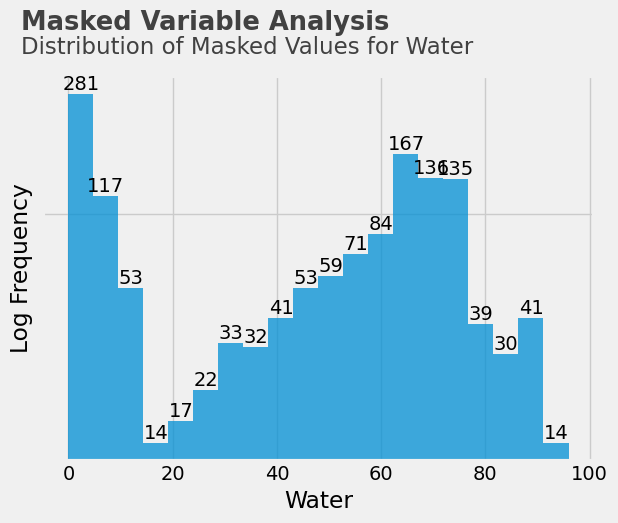

In [9]:
histogram(df = mask_water_df[mask_water_df['mask_ind_water']==1], col = 'water',output_prefix = f'{notebook_nm}-water-distribution',fig_dir = fig_dir, title = 'Masked Variable Analysis', subtitle = 'Distribution of Masked Values for Water', bins = 20, log_scale = True)

In [10]:
masker._corr_matrix['water'].nlargest(10)

water                          1.000000
carbohydrate                   0.785348
sugars                         0.497932
total_fat                      0.457254
fat                            0.457253
fiber                          0.414657
polyunsaturated_fatty_acids    0.388177
magnesium                      0.380786
monounsaturated_fatty_acids    0.358298
folate                         0.349385
Name: water, dtype: float64

In [11]:
masker._similar_ordered_index

original_index     score
0               4156  0.410755
1                440  0.419895
2               2028  0.421934
3               2714  0.422724
4               1827  0.423950
...              ...       ...
7194            6467  1.709007
7195            6418  1.719070
7196            6440  1.720736
7197            7192  1.771358
7198            7058  1.772475

[7199 rows x 2 columns]

In [12]:
masker = NumericalMasker()
mask_sugar_df = masker.mask(nutrition_df, 'sugars', k = 2, n = None, no_cols_frac = None, no_cols = 4, prob_range_non_mask = (0,0.3), prob_range_mask = (0.7,1), frac_na=0.2, rank_method = 'first', normalize_weights = False, selected_cols = None, seed = None,  max_corr = 0.9, min_corr = 0.3, col_weights = None)
mask_sugar_df[mask_sugar_df['mask_ind_sugars']==1]
na_sugar_df = convert_masked_rows_to_na(mask_sugar_df,'sugars')
na_sugar_df

INFO:root:Starting masking process for the sugars field.
INFO:root:Selecting key columns.
INFO:root:Masking 1439 rows which make up for 19.99% of the observations into 2 clusters.
INFO:root:Finished creating correlation matrix.
INFO:root:Finished creating ranking matrix.
INFO:root:Finished ordering similar rows.
INFO:root:Finished creating clusters in the dataframe.
INFO:root:Finished creating index weights.


name  serving_size  \
0                                          Nuts, pecans           100   
1                                        Teff, uncooked           100   
2                                       Sherbet, orange           100   
3                                      Cauliflower, raw           100   
4                                      Taro leaves, raw           100   
...                                                 ...           ...   
7194  Beef, raw, all grades, trimmed to 0" fat, sepa...           100   
7195  Lamb, cooked, separable lean only, composite o...           100   
7196  Lamb, raw, separable lean and fat, composite o...           100   
7197  Beef, raw, all grades, trimmed to 0" fat, sepa...           100   
7198  Beef, raw, all grades, trimmed to 0" fat, sepa...           100   

      total_fat  saturated_fat  cholesterol  sodium  choline  folate  \
0          72.0            6.2            0     0.0     40.5    22.0   
1           2.4            0.4            0    12.0     13.1     0.0   
2           2.0            1.2            1    46.0      7.7     4.0   
3           0.3            0.1            0    30.0     44.3    57.0   
4           0.7            0.2            0     3.0     12.8   126.0   
...         ...            ...          ...     ...      ...     ...   
7194        3.5            1.4           62    54.0     64.5     4.0   
7195        8.9            3.9          109    50.0      0.0     0.0   
7196       23.0           12.0           78    39.0      0.0     1.0   
7197        3.0            1.1           60    53.0     64.2     4.0   
7198        3.0            1.1           60    53.0     64.2     4.0   

      folic_acid  niacin  pantothenic_acid  riboflavin  thiamin  vitamin_a  \
0            0.0   1.167             0.863       0.130    0.660       56.0   
1            0.0   3.363             0.942       0.270    0.390        9.0   
2            0.0   0.063             0.224       0.097    0.027       46.0   
3            0.0   0.507             0.667       0.060    0.050        0.0   
4            0.0   1.513             0.084       0.456    0.209     4825.0   
...          ...     ...               ...         ...      ...        ...   
7194         0.0   6.422             0.356       0.234    0.063       11.0   
7195         0.0   7.680             0.580       0.500    0.130        0.0   
7196         0.0   6.550             0.520       0.320    0.130        0.0   
7197         0.0   6.720             0.355       0.184    0.063        4.0   
7198         0.0   6.720             0.355       0.184    0.063        6.0   

      vitamin_a_rae  carotene_alpha  carotene_beta  cryptoxanthin_beta  \
0               3.0             0.0           29.0                 9.0   
1               0.0             0.0            5.0                 0.0   
2              12.0             0.0            1.0                 5.0   
3               0.0             0.0            0.0                 0.0   
4             241.0             0.0         2895.0                 0.0   
...             ...             ...            ...                 ...   
7194            3.0             0.0            0.0                 0.0   
7195            0.0             0.0            0.0                 0.0   
7196            0.0             0.0            0.0                 0.0   
7197            1.0             0.0            0.0                 0.0   
7198            2.0             0.0            0.0                 0.0   

      lutein_zeaxanthin  vitamin_b12  vitamin_b6  vitamin_c  vitamin_d  \
0                  17.0         0.00       0.210        1.1        0.0   
1                  66.0         0.00       0.482        0.0        0.0   
2                   7.0         0.13       0.023        2.3        0.0   
3                   1.0         0.00       0.184       48.2        0.0   
4                1932.0         0.00       0.146       52.0        0.0   
...                 ...          ...   

Image found in the "reports/figures" folder saved under 2.0-masking-sugars-distribution_sugars_hist.png


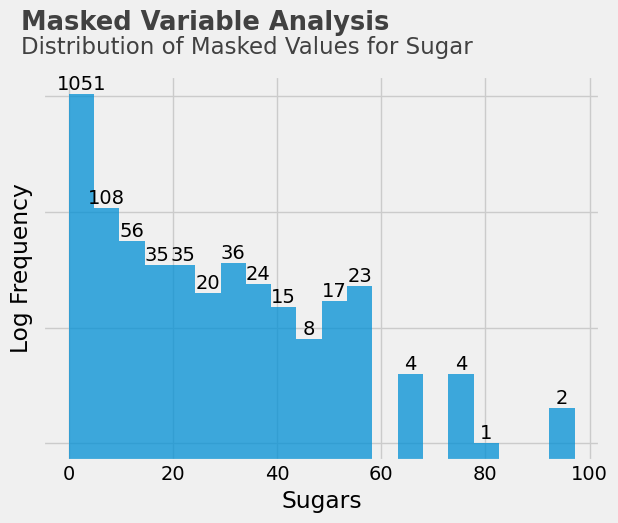

In [13]:
histogram(df = mask_sugar_df[mask_sugar_df['mask_ind_sugars']==1], col = 'sugars',output_prefix = f'{notebook_nm}-sugars-distribution',fig_dir = fig_dir, title = 'Masked Variable Analysis', subtitle = 'Distribution of Masked Values for Sugar', bins = 20, log_scale = True)

In [14]:
masker = NumericalMasker()
mask_alcohol_df = masker.mask(nutrition_df, 'alcohol', k = 10, n = None, no_cols_frac = None, no_cols = 1, prob_range_non_mask = (0,0.3), prob_range_mask = (0.7,1), frac_na=0.2, rank_method = 'first', normalize_weights = False, selected_cols = None, seed = None,  max_corr = 0.9, min_corr = 0.3, col_weights = None)
mask_alcohol_df[mask_alcohol_df['mask_ind_alcohol']==1]
na_alcohol_df = convert_masked_rows_to_na(mask_alcohol_df,'alcohol')

INFO:root:Starting masking process for the alcohol field.
INFO:root:Selecting key columns.
INFO:root:Masking 1439 rows which make up for 19.99% of the observations into 10 clusters.
INFO:root:Finished creating correlation matrix.
INFO:root:Finished creating ranking matrix.
INFO:root:Finished ordering similar rows.
INFO:root:Finished creating clusters in the dataframe.
INFO:root:Finished creating index weights.


Image found in the "reports/figures" folder saved under 2.0-masking-alcohol-distribution_alcohol_hist.png


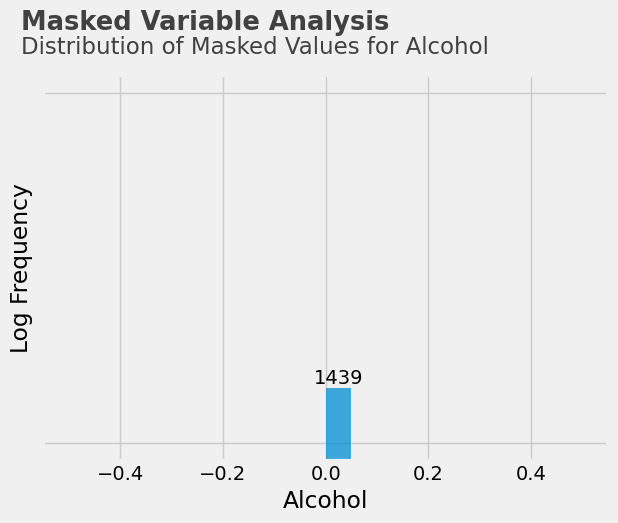

In [15]:
histogram(df = mask_alcohol_df[mask_alcohol_df['mask_ind_alcohol']==1], col = 'alcohol',output_prefix = f'{notebook_nm}-alcohol-distribution',fig_dir = fig_dir, title = 'Masked Variable Analysis', subtitle = 'Distribution of Masked Values for Alcohol', bins = 20, log_scale = True)

In [16]:
# Import R's base package
base = importr("base")

# Import R's utility packages
utils = importr("utils")

# Select mirror 
utils.chooseCRANmirror(ind=1)

# For automatic translation of Pandas objects to R
pandas2ri.activate()

# Enable R magic
%load_ext rpy2.ipython

globalenv["r_mask_alcohol_df"] = na_alcohol_df
globalenv["r_mask_sugar_df"] = na_sugar_df
globalenv["r_mask_water_df"] = na_water_df

In [17]:
# utils.install_packages("remotes")
# %R remotes::install_github("njtierney/naniar")

In [18]:
%R library(naniar)

<rpy2.robjects.vectors.StrVector object at 0x000002451F58C9C0> [RTYPES.STRSXP]
R classes: ('character',)
['naniar', 'tools', 'stats', 'graphics', ..., 'utils', 'datasets', 'methods', 'base']

In [19]:
# globalenv["r_mask_alcohol_df"] = mask_alcohol_df
# globalenv["r_mask_sugar_df"] = mask_sugar_df
# globalenv["r_mask_water_df"] = mask_water_df

In [24]:
# %R mcar_test(r_mask_alcohol_df[c("saturated_fat")])
%R mcar_test(r_mask_alcohol_df[c("alcohol")])
# %R mcar_test(r_mask_alcohol_df)

statistic   df  p.value  missing.patterns
1  1.837553e-27  0.0      0.0                 2

In [21]:
%R mcar_test(r_mask_sugar_df[c("sugars")])

statistic   df  p.value  missing.patterns
1  1.872327e-26  0.0      0.0                 2

In [22]:
%R mcar_test(r_mask_water_df[c("water")])

statistic   df  p.value  missing.patterns
1  1.207131e-26  0.0      0.0                 2